# Analysis of Pitch Quality using MLB PITCHf/x Data
__By Jacob Christensen__

## Introduction

Pitching a baseball is considered by many to be an art form. There are countless different ways to structure a stance, delivery, and release and all of that takes place before the ball even leaves the pitcher's hand. Once the ball is in the air, things like speed, spin rate, and trajectory will affect the path of the ball as it travels towards home plate. Each of these different factors play their own part in determining the "quality" of the pitch. In this analysis, the expected number of bases gained by the batter will be used as the metric for pitch quality.

Hundreds of thousands of pitches are thrown every year by professional pitchers in the MLB. In order to accurately track each of these pitches and provide feedback to umpires making calls on each of them, the MLB employs a system called "PITCHf/x". This system was created by a company called Sportvision that worked in tandem with the MLB to get it installed in every professional baseball stadium in the country. "PITCHf/x" typically utilizes three cameras mounted in each stadium to track what kind of pitch was thrown, the path of the ball during its flight, the speed of the pitch, and many other statistics. The system also reports the outcome of the pitch (i.e. ball, strike, out, single, etc.).  

This project aims to analyze the different aspects of pitches thrown by multiple pitchers to determine what has the greatest affect on the "quality" of the pitch. The variables that are being targeted for this analysis are:
        
        pitch type, velocity, spin rate, zone, pitcher handedness, batter handedness, pitch count, pitch number,
        number of outs, release point
        
Some questions that this information will attempt to answer are:

        Does the handedness of a pitcher have a significant impact on average pitch quality?
        What part of the delivery should a pitcher focus on the most to increase pitch quality?
        Are there any major features that indicate a lower average pitch quality?

__Data Source:__ https://baseballsavant.mlb.com/     

__Reference Sources:__  
- The Quality of Pitches in Major League Baseball (http://people.stat.sfu.ca/~tim/papers/pitching.pdf)
- Spin Rate: Why is it so Important for Baseball (http://www.yakkertech.com/2019/05/14/spin-rate-why-is-it-so-important-for-baseball/)


## Importing and Cleaning the Data

This section focuses on preprocessing the data that will be used in the analysis to follow. First, however, the environment must be setup using imports.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

The data set that this project will work with consists of eight different pitchers in an attempt to gain a broad spectrum on some of the different pitching styles used in the MLB. Half of the pitchers are in starting roles and half are in relief roles, as well as half of the pitchers are left handed and the other half are right handed.

In [2]:
starting_left1 = pd.read_csv("savant_data_kershaw.csv")
starting_left2 = pd.read_csv("savant_data_sale.csv")
starting_right1 = pd.read_csv("savant_data_verlander.csv")
starting_right2 = pd.read_csv("savant_data_greinke.csv")

relief_left1 = pd.read_csv("savant_data_claudio.csv")
relief_left2 = pd.read_csv("savant_data_kolarek.csv")
relief_right1 = pd.read_csv("savant_data_petit.csv")
relief_right2 = pd.read_csv("savant_data_suero.csv")

The data was first read into multiple DataFrames seperated by pitcher. These sets can also be appended together to make one large set that can be analyzed using one DataFrame.

In [3]:
pitch_data = starting_left1
pitch_data = pitch_data.append([starting_left2,starting_right1,starting_right2,
                               relief_left1,relief_left2,relief_right1,relief_right2],
                               sort=False)
pitch_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15835 entries, 0 to 1209
Data columns (total 89 columns):
pitch_type                         15561 non-null object
game_date                          15835 non-null object
release_speed                      15504 non-null float64
release_pos_x                      15503 non-null float64
release_pos_z                      15503 non-null float64
player_name                        15835 non-null object
batter                             15835 non-null int64
pitcher                            15835 non-null int64
events                             4074 non-null object
description                        15835 non-null object
spin_dir                           0 non-null float64
spin_rate_deprecated               0 non-null float64
break_angle_deprecated             0 non-null float64
break_length_deprecated            0 non-null float64
zone                               15503 non-null float64
des                                4074 non-null

Now that all of the pitching data is together, the data can be cleaned to make further analyis easier.  
The first step in cleanig this set is dropping columns that are empty or have been deprecated in the PITCHf/x system. These variables will not be useful when analyzing the data.

In [4]:
pitch_data = pitch_data.drop(columns=['spin_dir','spin_rate_deprecated','break_angle_deprecated',
                                      'break_length_deprecated','tfs_deprecated','tfs_zulu_deprecated',
                                      'umpire'])

With the empty columns dropped, each remaining columns will provide information regarding the status of the game, pitch, or batter for each entry in the set.

In [5]:
pitch_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15835 entries, 0 to 1209
Data columns (total 82 columns):
pitch_type                         15561 non-null object
game_date                          15835 non-null object
release_speed                      15504 non-null float64
release_pos_x                      15503 non-null float64
release_pos_z                      15503 non-null float64
player_name                        15835 non-null object
batter                             15835 non-null int64
pitcher                            15835 non-null int64
events                             4074 non-null object
description                        15835 non-null object
zone                               15503 non-null float64
des                                4074 non-null object
game_type                          15835 non-null object
stand                              15835 non-null object
p_throws                           15835 non-null object
home_team                          15

With the empty columns gone, the next issue that can be tackled is handling missing data in the remaining features. For some of the critcal features, or those that have previously been estimated to have a major impact on the quality of the pitch, the rows will simply have to be removed to eliminate large sources of error. These features include pitch type, velocity, spin rate, handedness of the pitcher and batter, pitch count, and pitch zone.

In [6]:
all_names = ['pitch_type','release_speed','release_spin_rate','zone']
pitch_data = pitch_data[~pitch_data['pitch_type'].isnull()]
pitch_data = pitch_data[~pitch_data['release_speed'].isnull()]
pitch_data = pitch_data[~pitch_data['release_spin_rate'].isnull()]
pitch_data = pitch_data[~pitch_data['zone'].isnull()]

One of the other critical features to consider when evaluating pitches is the outcome. This analysis is focused on the number of bases gained from each pitch, which is described by the events and description features of the data set. The events feature has null values for all pitches that do not end the at-bat, but the description feature has information about every pitch.   
Using this information, the null values in the events feature can be replaced with pitch events.

In [7]:
pitch_data['events'] = pitch_data['events'].fillna("pitch")

With some of the rows removed, the DataFrame information can be checked again to ensure that each of the previously mentioned critical columns does not have any missing values.

In [8]:
pitch_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15352 entries, 0 to 1209
Data columns (total 82 columns):
pitch_type                         15352 non-null object
game_date                          15352 non-null object
release_speed                      15352 non-null float64
release_pos_x                      15352 non-null float64
release_pos_z                      15352 non-null float64
player_name                        15352 non-null object
batter                             15352 non-null int64
pitcher                            15352 non-null int64
events                             15352 non-null object
description                        15352 non-null object
zone                               15352 non-null float64
des                                3948 non-null object
game_type                          15352 non-null object
stand                              15352 non-null object
p_throws                           15352 non-null object
home_team                          1

With all of the events filled out, a new feature can be engineered to show the number of bases gained from each pitch. The number of bases for each of the balls hit into play will be taken directly from the result of the play. Probable bases from balls and strikes have been calculated based off of the pitch count from Swartz, P., Grosskopf, Bingham, & Swartz, T. (2016).

In [9]:
bases = []
ball_count_bases = np.array([[0.51,0.61,0.79],[0.42,0.51,0.69],[0.32,0.39,0.55]])
strike_count_bases = np.array([[0.37,0.42,0.51,0.68],[0.28,0.31,0.38,0.54],[0.28,0.31,0.38,0.54]])
for index, rows in pitch_data.iterrows() :
    if (rows['events'] == 'pitch' ) :
        if(rows['type'] == 'B') :
            bases.append(ball_count_bases[rows['strikes']][rows['balls']])
        else :
            bases.append(strike_count_bases[rows['strikes']][rows['balls']])
    elif(rows['events'] == 'single' or rows['events'] == 'hit_by_pitch' or rows['events'] == 'walk'):
        bases.append(1)
    elif(rows['events'] == 'double') :
        bases.append(2)
    elif(rows['events'] == 'triple') :
        bases.append(3)
    elif(rows['events'] == 'home_run') :
        bases.append(4)
    else :
        bases.append(0)
        
        
pitch_data['bases'] = bases

Now that the null values have been dealt with and the bases have been calculated, a subset of them can be checked to make sure that they are good candidates to be categorical variables.

In [10]:
print("Number of Unique Pitch Types: " + str(len(set(pitch_data["pitch_type"]))))
print("Number of Unique Pitch Result Types: " + str(len(set(pitch_data["type"]))))
print("Number of Unique Events: " + str(len(set(pitch_data["events"]))))
print("Number of Unique Descriptions: " + str(len(set(pitch_data["description"]))))
print("Number of Unique Handedness: " + str(len(set(pitch_data["p_throws"]))))
print("Number of Unique Ball Counts: " + str(len(set(pitch_data["balls"]))))
print("Number of Unique Strike Counts: " + str(len(set(pitch_data["strikes"]))))
print("Number of Unique Pitch Numbers: " + str(len(set(pitch_data["pitch_number"]))))
print("Number of Unique Outs: " + str(len(set(pitch_data["outs_when_up"]))))
print("Number of Unique Zones: " + str(len(set(pitch_data["zone"]))))

Number of Unique Pitch Types: 9
Number of Unique Pitch Result Types: 3
Number of Unique Events: 25
Number of Unique Descriptions: 13
Number of Unique Handedness: 2
Number of Unique Ball Counts: 4
Number of Unique Strike Counts: 3
Number of Unique Pitch Numbers: 13
Number of Unique Outs: 3
Number of Unique Zones: 13


Each of the features listed above, as well as batter stance, are good candidates to be categories  
The following code shifts each of them to be represented as categories.

In [11]:
cat_names = ["pitch_type", "type", "events", "description", "p_throws", "balls", "strikes", "outs_when_up", "zone", "stand",
            "pitch_number"]

for name in cat_names :
    pitch_data[name] = pitch_data[name].astype("category")
    
# Append relevant features to list of all features
for name in ["p_throws", "balls", "strikes", "outs_when_up", "stand", "pitch_number"] :
    all_names.append(name)

Finally, the data set that will be analyzed can be be shown using the head and info functions.

In [12]:
pitch_data.head(60)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,bases
0,FF,2019-09-29,90.5,1.3508,6.1911,Clayton Kershaw,518516,477132,field_out,hit_into_play,...,5,0,5,5,0,0,5,Infield shift,Standard,0.00
1,FF,2019-09-29,91.1,1.3839,6.1994,Clayton Kershaw,518516,477132,pitch,foul,...,5,0,5,5,0,0,5,Infield shift,Standard,0.54
2,FF,2019-09-29,89.7,1.4225,6.2320,Clayton Kershaw,518516,477132,pitch,ball,...,5,0,5,5,0,0,5,Infield shift,Standard,0.55
3,FF,2019-09-29,90.3,1.3502,6.2253,Clayton Kershaw,518516,477132,pitch,called_strike,...,5,0,5,5,0,0,5,Infield shift,Standard,0.38
4,FF,2019-09-29,90.1,1.4813,6.3368,Clayton Kershaw,518516,477132,pitch,ball,...,5,0,5,5,0,0,5,Infield shift,Standard,0.51
5,FF,2019-09-29,90.7,1.2976,6.3329,Clayton Kershaw,518516,477132,pitch,ball,...,5,0,5,5,0,0,5,Infield shift,Standard,0.42
6,FF,2019-09-29,90.8,1.3868,6.2242,Clayton Kershaw,518516,477132,pitch,foul,...,5,0,5,5,0,0,5,Infield shift,Standard,0.37
7,SL,2019-09-29,86.9,1.3294,6.3412,Clayton Kershaw,664041,477132,strikeout,swinging_strike_blocked,...,5,0,5,5,0,0,5,Infield shift,Standard,0.00
8,SL,2019-09-29,86.5,1.3640,6.3510,Clayton Kershaw,664041,477132,pitch,foul,...,5,0,5,5,0,0,5,Infield shift,Standard,0.38
9,SL,2019-09-29,85.7,1.3870,6.4169,Clayton Kershaw,664041,477132,pitch,foul,...,5,0,5,5,0,0,5,Infield shift,Standard,0.38


In [13]:
pitch_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15352 entries, 0 to 1209
Data columns (total 83 columns):
pitch_type                         15352 non-null category
game_date                          15352 non-null object
release_speed                      15352 non-null float64
release_pos_x                      15352 non-null float64
release_pos_z                      15352 non-null float64
player_name                        15352 non-null object
batter                             15352 non-null int64
pitcher                            15352 non-null int64
events                             15352 non-null category
description                        15352 non-null category
zone                               15352 non-null category
des                                3948 non-null object
game_type                          15352 non-null object
stand                              15352 non-null category
p_throws                           15352 non-null category
home_team                

## Exploratory Data Analysis

This section will focus on exploring the features in this data set and the relationship that they have to the number of bases yielded. The features that will be examined are as follows:
        
        pitch_type, release_speed, release_spin_rate, zone, p_throws and stand, pitch_number, balls and strikes, 
        release_point_x and release_point_z
        
The first plot shows the distribution of the pitch types using a bar plot.

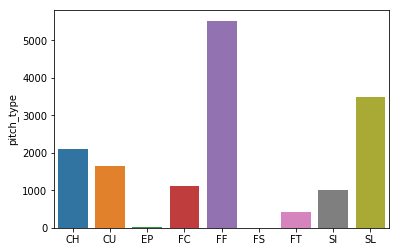

In [14]:
type_counts = pitch_data["pitch_type"].value_counts()
sbn.barplot(x=type_counts.index, y=type_counts)

The bar plot shows that over 1/3 of all of the pitches thrown are four-seam fastballs, with sliders, changeups, and curveballs being the next most common in that order. The next plot will show the distributions of bases yielded per pitch type using a box plot.

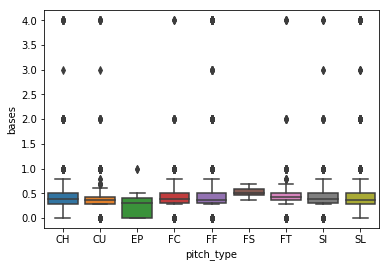

In [15]:
sbn.boxplot(x="pitch_type",y="bases",data=pitch_data)

This plot does not reveal strong correlation between the number of bases yielded and the pitch type. One thing to notice, however, is that changeups and sliders seem to be the most volatile between 0 and 1.0 bases yielded. This shows that these pitches lead to outs more often than the others relative to the number of pitches thrown.  
Next is the distribution of the release speeds will be plotted using a histogram.

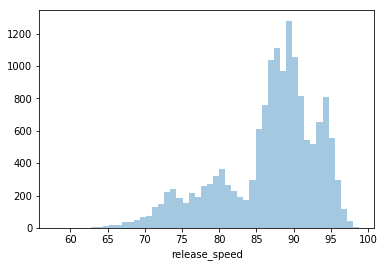

In [16]:
sbn.distplot(pitch_data["release_speed"],kde=False)

The histogram shows a significant portion of the pitches thrown are within the 85-92mph range. This is typically the range in which multiple pitch types can be thrown.  
Now, the relationship between release speed and bases yielded will be explored using a joint plot.

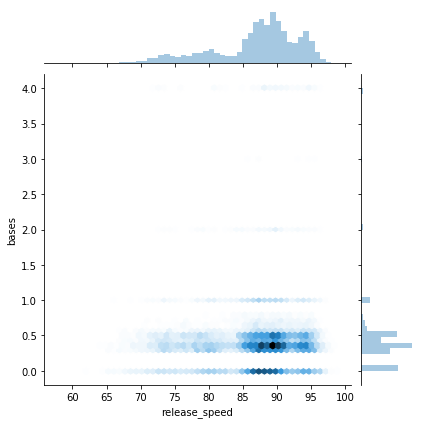

In [17]:
sbn.jointplot(x="release_speed",y="bases",data=pitch_data, kind="hex")

This plot does not reveal much of a correlation between the release speed and number of bases yielded; however, close examination of the high and low speed areas of the plot does show that the average number of bases yielded drops around these extremes. This is likely due to a lack of data for these regions.  
The next variable to be examined is the release spin rate. The first plot will be a histogram showing the distribution of the values in this column.

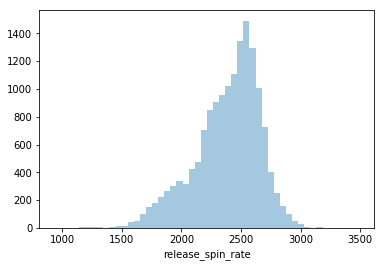

In [18]:
sbn.distplot(pitch_data["release_spin_rate"],kde=False)

The histogram shows that the average spin rate is around 2500 rotations per minute (rpm). The plot also shows that the range of this variable extends from around 1000 rpm all the way to nearly 3500 rpm.  
The next plot will show the relationship to bases yielded, again using a joint plot.

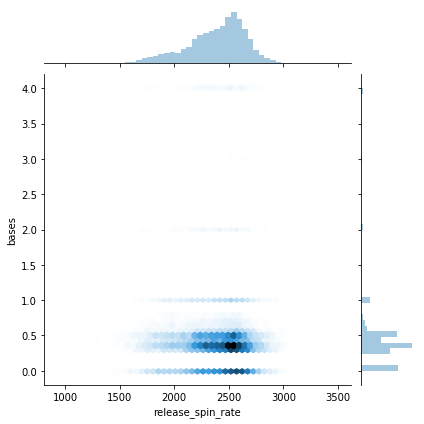

In [19]:
sbn.jointplot(x="release_spin_rate",y="bases",data=pitch_data, kind="hex")

The plot shows a stronger correlation than with the release speed. With the bases yielded being the lowest near the right and left edges of the plot. This is likely because very high and very low spin rates can cause the ball to move significantly farther in flight, making it much more difficult for the batter to predict its location.  
The next variable to be analyzed is the zone. The zones are laid out as follows:   

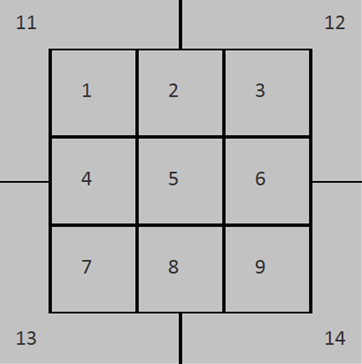  

The first plot will show the distribution of pitches using a bar chart.

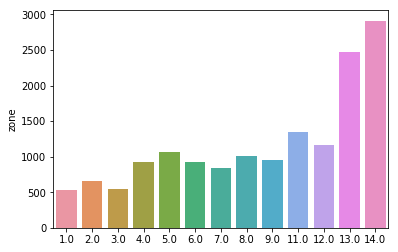

In [20]:
zone_counts = pitch_data["zone"].value_counts()
sbn.barplot(x=zone_counts.index, y=zone_counts)

The bar plot shows that the higher zones are typically avoided, while low and outside the strikezone are targeted frequently.  
Next, a box plot will be used to show the relationship between the zone and the bases yielded.

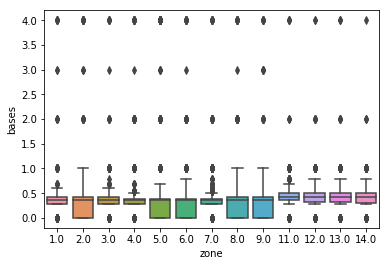

In [21]:
sbn.boxplot(x="zone",y="bases",data=pitch_data)

The boxplot shows that the number of bases yielded is typically lowest when throwing to the 2, 5, 6, 8, or 9 zones. The amount of hits for multiple bases, however, is lower when throwing to the 11, 12, 13, or 14 zones. This is likely because these zones are outside the strike zone and do not incentivize the hitter to swing as often.  
The next features to be examined are the pitcher and batter handedness. These will be evaluated at the same time because the combinations of pitcher and batter handedness are often considered when picking matchups in games. The first two plots show the pitcher and batter handedness distributions using bar plots.

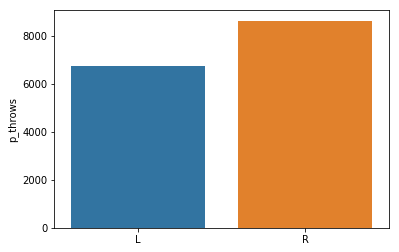

In [22]:
throw_counts = pitch_data["p_throws"].value_counts()
sbn.barplot(x=throw_counts.index, y=throw_counts)

This plot shows that there are about 6500 pitches thrown by left handed pitchers and 8500 pitches thrown by right handed pitchers in the data set.

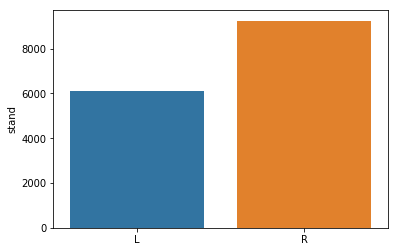

In [23]:
stand_counts = pitch_data["stand"].value_counts()
sbn.barplot(x=stand_counts.index, y=stand_counts)

This plot shows that there are about 6000 pitches taken by left handed batters and 9000 pitches taken by right handed batters in the data set. Next, a heat map will be used to show the average bases yielded to the combinations of left and right handed batters and pitchers.

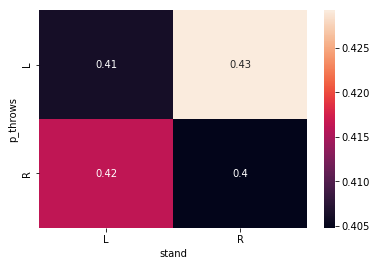

In [24]:
stance_hm_data = pd.pivot_table(pitch_data, values="bases", index=["p_throws"], columns="stand")
sbn.heatmap(stance_hm_data, annot=True)

The heatmap shows that the best matchup for the pitcher is when both are right handed while the worst is when the pitcher is left handed and the batter is right handed.  
The next variable to be analyzed is the pitch number for the at-bat. The first plot will show a distribution of the data points using a bar plot.

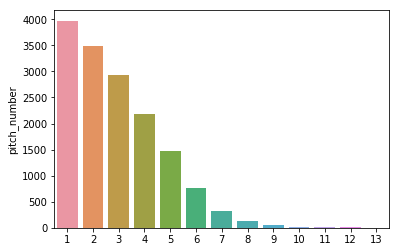

In [25]:
pitch_counts = pitch_data["pitch_number"].value_counts()
sbn.barplot(x=pitch_counts.index, y=pitch_counts)

The histogram shows that pitchers in this data set typically pitch 4-5 pitches per at-bat and 13 is the most pitches thrown to one batter. The next plot shows the relationship between pitch number and bases yielded, using a boxplot.

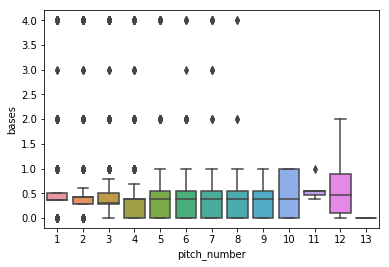

In [26]:
sbn.boxplot(x="pitch_number",y="bases",data=pitch_data)

The plot shows that the distribution of bases yielded gets wider as the pitch number in the at-bat goes up.  
Next, the count of balls and strikes will be examined. First, the balls and strikes will each be characterized with bar plots.

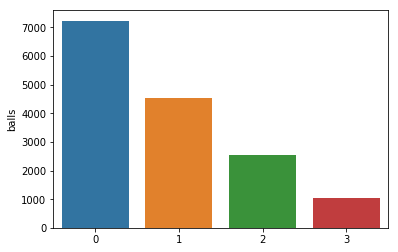

In [27]:
ball_counts = pitch_data["balls"].value_counts()
sbn.barplot(x=ball_counts.index, y=ball_counts)

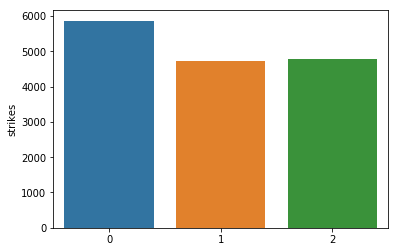

In [28]:
strike_counts = pitch_data["strikes"].value_counts()
sbn.barplot(x=strike_counts.index, y=strike_counts)

The plots show that the number of pitches decreases as the number of balls and strikes decreases. The next plot shows a heat map of the pitch quality for each of the possible pitch counts.

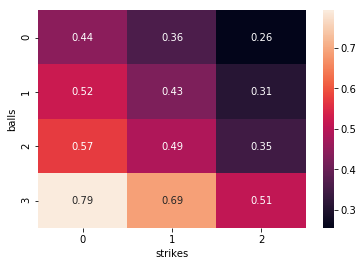

In [29]:
count_hm_data = pd.pivot_table(pitch_data, values="bases", index=["balls"], columns="strikes")
sbn.heatmap(count_hm_data, annot=True)

As shown in the heat map, the number of bases yielded tends to decrease as the number of strikes increase and the number of balls decrease.  
The final variable to explore is the release point. The release point consists of an x-coordinate and a z-coordinate, both of which will be characterized in the histograms below.

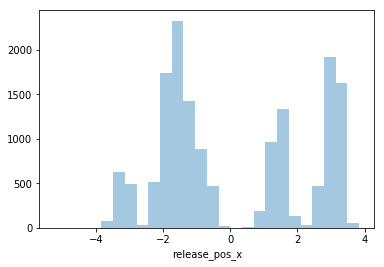

In [30]:
sbn.distplot(pitch_data["release_pos_x"],kde=False)

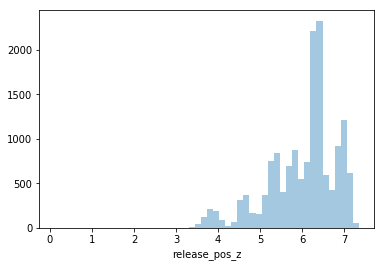

In [31]:
sbn.distplot(pitch_data["release_pos_z"],kde=False)

The histograms show that the majority of release points are around 6.5 feet above the ground and 2 feet left of the body or 3 feet right of the body.  
The final plots utilize hex plots to show the bases yielded with the different combinations of veritcal and horizontal release points.

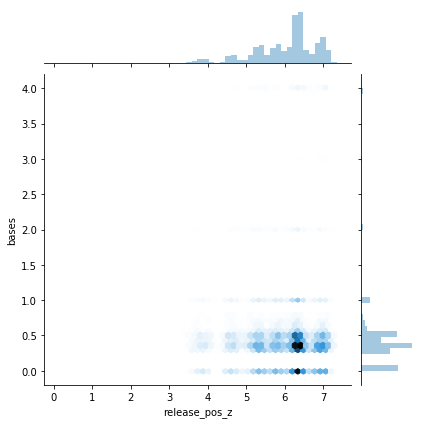

In [32]:
sbn.jointplot(x="release_pos_z",y="bases",data=pitch_data, kind="hex")

The hex plot shows that the large majority of pitches are thrown at about 6.5 feet above the ground, but there does not seem to be a strong correlation between the bases yielded and vertical release point.

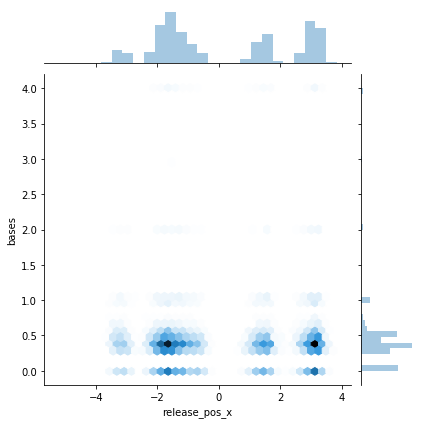

In [33]:
sbn.jointplot(x="release_pos_x",y="bases",data=pitch_data, kind="hex")

The hex plot shows that the large majority of pitches are thrown about 2 feet to the left of center for left handed pitchers and 3 feet to the right of center for right handed pitchers, but there also does not seem to be a strong correlation between the bases yielded and horizontal release point that can be drawn from looking at the plot.

## Linear Regression Modeling  

Now that the target features have been analyzed, they can be used in a few different machine learning models to determine how they affect the accuracy of the models. This section will focus on creating and evaluating these models to determine which features have the most predictive power.  
This process starts by creating dummy variables for all of the categorical variables that will be used.

In [34]:
dummy_cols =  {}
for name in cat_names :
    dummies = pd.get_dummies(pitch_data[name], prefix=name)
    dummy_cols[name] = dummies.columns.values
    for dum_name in dummies.columns.values :
        pitch_data[dum_name] = dummies[dum_name]
    pitch_data = pitch_data.drop(columns = name)

In [35]:
pitch_data.head()

,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,des,game_type,home_team,...,pitch_number_4,pitch_number_5,pitch_number_6,pitch_number_7,pitch_number_8,pitch_number_9,pitch_number_10,pitch_number_11,pitch_number_12,pitch_number_13
0,2019-09-29,90.5,1.3508,6.1911,Clayton Kershaw,518516,477132,Madison Bumgarner lines out to third baseman J...,R,SF,...,0,0,0,1,0,0,0,0,0,0
1,2019-09-29,91.1,1.3839,6.1994,Clayton Kershaw,518516,477132,NaN,R,SF,...,0,0,1,0,0,0,0,0,0,0
2,2019-09-29,89.7,1.4225,6.2320,Clayton Kershaw,518516,477132,NaN,R,SF,...,0,1,0,0,0,0,0,0,0,0
3,2019-09-29,90.3,1.3502,6.2253,Clayton Kershaw,518516,477132,NaN,R,SF,...,1,0,0,0,0,0,0,0,0,0
4,2019-09-29,90.1,1.4813,6.3368,Clayton Kershaw,518516,477132,NaN,R,SF,...,0,0,0,0,0,0,0,0,0,0


Now that the dummy variables have been created, and the head() function confirmed that the columns are correctly in place, the linear regression models can be created.
The next part to creating these models is defining the training and testing sets that will be used for training and evaluation.

In [36]:
train_set, test_set = train_test_split(pitch_data)
print(pitch_data.shape[0],train_set.shape[0],test_set.shape[0])

15352 11514 3838


The printed shapes of the training and testing set show that the training set is made up as 75% of the data set and the testing set is the other 25%.  
The fit method, from Scikit Learn, that will be used in this analysis takes two parameters: a feature matrix and a 1-dimensional vector of outcomes. The first things that will be created are the outcome vectors for the training and testing sets and a basic feature matrix. 

In [37]:
x_train = train_set[["release_speed"]].values
x_test = test_set[["release_speed"]].values
y_train = train_set["bases"].values
y_test = test_set["bases"].values

print(type(x_train), x_train.shape, x_train.dtype)
print(type(y_train), y_train.shape, y_train.dtype)

<class 'numpy.ndarray'> (11514, 1) float64
<class 'numpy.ndarray'> (11514,) float64


### Base Model

This model will be created using only the intercept, forming the baseline to test the accuracy of the rest of the models against. The equation that will be fit is:  
\begin{align}
\hat{y}=\beta_0
\end{align}   
Where \\( \hat{y} \\) is the predicted number of yielded bases and \\( \beta_0\\) is the constant intercept.   
To build this model, a feature matrix of all zeroes can be created for training and testing.

In [38]:
train_zeros = np.zeros(x_train.shape)
test_zeros = np.zeros(x_test.shape)

Now, this set can be used with the SGDRegressor class in Scikit Learn to build the baseline model and train it using the fit() function, passing in the matrix of zeros and the expected outcomes.

In [39]:
base = SGDRegressor(max_iter=5000)
base.fit(train_zeros, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=5000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

Now the model can be applied to the testing set to predict number of bases yielded.

In [40]:
base_pred_bases = base.predict(test_zeros)

The model can be evaluated using mean squared error and root-mean squared error methods from Scikit Learn.

In [41]:
base_mse = mean_squared_error(y_test, base_pred_bases)
base_rmse = np.sqrt(base_mse)

print("Base Model MSE:", base_mse)
print("Base Model RMSE:", base_rmse)

Base Model MSE: 0.23315157931553196
Base Model RMSE: 0.4828577216070299


This shows that the RMS error between the predicted number of bases and the true number is very large, around 0.4, considering the range of bases is only 0-4. The differences between the prices can be visualized using a scatter plot.

Text(0, 0.5, 'Predicted Bases')

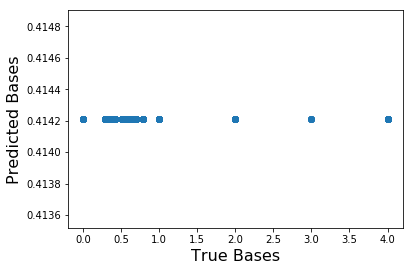

In [42]:
sbn.regplot(x=y_test, y=base_pred_bases, fit_reg=False)
plt.xlabel("True Bases", fontsize=16)
plt.ylabel("Predicted Bases", fontsize=16)

The baseline model does not take in any features, so it just predicts the average number of bases for every pitch.

### Multiple Linear Regression

Next, the predicted features of importance can be introduced in an attempt create a model that reduces the error. These features are the pitch type, release speed, spin rate, pitch count, and release point. The feature matrices can be created using the function below. This function takes in the selected columns and determines if they are categorical or numerical, then it creates a feature matrix for each type of feature and concatenates them to form the final feature matrix.

In [43]:
def create_feature_matrix(df_train, df_test, sel_columns, dum_columns) :
    if dum_columns is None:
        dum_columns = dict()
    
    # keep track of the features
    numerical_cols = []
    categorical_cols = []
    
    # Determine which features are categorical and numerical
    for name in sel_columns :
        if name in dum_columns:
            categorical_cols.extend(dum_columns[name])
        else :
            numerical_cols.append(name)
            
    # Select and process the numerical features by transforming to float64 type and scaling
    if len(numerical_cols) > 0:
        x_train_num = df_train[numerical_cols].astype("float64").values
        x_test_num = df_test[numerical_cols].astype("float64").values
        
        scaler = StandardScaler()
        x_train_num = scaler.fit_transform(x_train_num)
        x_test_num = scaler.fit_transform(x_test_num)
        
    # Select the categorical features    
    if len(categorical_cols) > 0:
        x_train_cat = df_train[categorical_cols].astype("float64").values
        x_test_cat = df_test[categorical_cols].astype("float64").values
        
    if len(numerical_cols) > 0 and len(categorical_cols) > 0:
        x_train = np.hstack([x_train_num, x_train_cat])
        x_test = np.hstack([x_test_num, x_test_cat])
    elif len(numerical_cols) > 0:
        x_train = x_train_num
        x_test = x_test_num
    else:
        x_train = x_train_cat
        x_test = x_test_cat
    
    return x_train, x_test

Using this function, the selected columns can be passed in to get the appropriate feature matrix.

In [44]:
sel_cols = ["pitch_type", "release_speed", "balls", "strikes", "zone", "release_spin_rate"]
x_train, x_test = create_feature_matrix(train_set, test_set, sel_cols, dummy_cols)

Now the feature matrices have been created, the model can be trained, used to predict the number of bases, and evaluated to determine the error.

In [45]:
mlr_model = SGDRegressor(max_iter=5000)
mlr_model.fit(x_train, y_train)

mlr_pred_bases = mlr_model.predict(x_test)

mlr_mse = mean_squared_error(y_test, mlr_pred_bases)
mlr_rmse = np.sqrt(mlr_mse)

print("Predicted Features Model MSE:", mlr_mse)
print("Predicted Features Model RMSE:", mlr_rmse)

Predicted Features Model MSE: 0.22487674040351815
Predicted Features Model RMSE: 0.47421170420342657


Using this model, the error has shown marginal improvement from the baseline. The scatterplot below shows the new predicted bases plotted against the true bases yielded.

Text(0, 0.5, 'Predicted Bases')

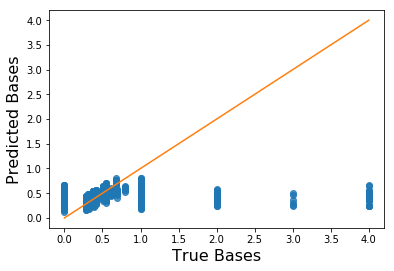

In [46]:
sbn.regplot(x=y_test, y=mlr_pred_bases, fit_reg=False)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)])
plt.xlabel("True Bases", fontsize=16)
plt.ylabel("Predicted Bases", fontsize=16)

As seen in the scatteplot, the predictions have begun to consider the features but are still not very accurate.

### Linear Regression with Categories

The next linear regression model will take in just the categorical variables to test their predictive power.

In [47]:
cat_cols = ["pitch_type", "zone", "p_throws", "balls", "strikes", "outs_when_up", "stand", "pitch_number"]
x_train, x_test = create_feature_matrix(train_set, test_set, cat_cols, dummy_cols)

Now the feature matrices have been created, the new model can be trained, used to predict the number of bases, and evaluated to determine the error.

In [48]:
cat_model = SGDRegressor(max_iter=5000)
cat_model.fit(x_train, y_train)

cat_pred_bases = cat_model.predict(x_test)

mlr_mse = mean_squared_error(y_test, cat_pred_bases)
mlr_rmse = np.sqrt(mlr_mse)

print("Categorical Model MSE:", mlr_mse)
print("Categorical Model RMSE:", mlr_rmse)

Categorical Model MSE: 0.22521762597964698
Categorical Model RMSE: 0.47457099150669435


The new model utilizing only the categorical variables shows slightly less accuracy. The scatterplot below shows the new predicted bases plotted against the true bases yielded.

Text(0, 0.5, 'Predicted Bases')

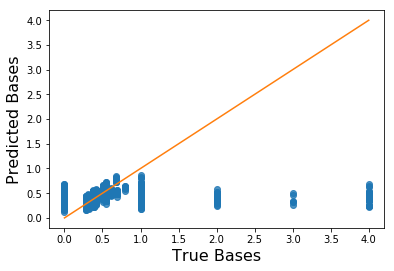

In [49]:
sbn.regplot(x=y_test, y=cat_pred_bases, fit_reg=False)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)])
plt.xlabel("True Bases", fontsize=16)
plt.ylabel("Predicted Bases", fontsize=16)

As seen in the scatteplot, the predictions have slightly closer to a linear relation with the true values,.  

### Greedy Algorithm

Next, a Greedy Algorithm approach will be taken to attempt to further reduce the error in predicting the bases yielded. This method starts by building a simple linear regression model for each feature and sorting the features from lowest to highest error. The following function will perform this function.

In [50]:
def sort_features(df_train, df_test, y_train, y_test, columns, dum_columns):
    rmses = []
    # Loop to iterate over all columns
    for name in columns :
        x_train, x_test = create_feature_matrix(df_train, df_test,
                                                 [name], dum_columns)
        
        simple_lr = SGDRegressor(max_iter=5000, tol=None)
        simple_lr.fit(x_train, y_train)
        simple_lr_pred = simple_lr.predict(x_test)
        simple_mse = mean_squared_error(y_test, simple_lr_pred)
        simple_rmse = np.sqrt(simple_mse)
        print(name + " Model MSE:", simple_mse)
        print(name + " Model RMSE:", simple_rmse)
        print()
        rmses.append((simple_rmse, name))
        
    # sort by the value of the rmse    
    rmses.sort(key=lambda p: p[0])
    sorted_columns = [name for _, name in rmses]
    print("Sorted Columns: " + str(sorted_columns))
    return sorted_columns

This function can then be used with all of the variables that considered in this data set.

In [51]:
for name in ["release_pos_x", "release_pos_z"] :
    all_names.append(name)
sorted_cols = sort_features(train_set, test_set, y_train, y_test, all_names, dummy_cols)

pitch_type Model MSE: 0.23274044971099858
pitch_type Model RMSE: 0.48243180835326205

release_speed Model MSE: 0.2331868189402139
release_speed Model RMSE: 0.48289421092017026

release_spin_rate Model MSE: 0.23302776799774758
release_spin_rate Model RMSE: 0.4827294977497725

zone Model MSE: 0.2339742257401845
zone Model RMSE: 0.48370882330197834

p_throws Model MSE: 0.23306904188868374
p_throws Model RMSE: 0.4827722463943881

balls Model MSE: 0.23063356960572604
balls Model RMSE: 0.4802432400416752

strikes Model MSE: 0.23007192475995347
strikes Model RMSE: 0.47965813321568257

outs_when_up Model MSE: 0.2332871141106807
outs_when_up Model RMSE: 0.4829980477296784

stand Model MSE: 0.23313780591955044
stand Model RMSE: 0.48284345902119297

pitch_number Model MSE: 0.23330351282859677
pitch_number Model RMSE: 0.48301502339844127

release_pos_x Model MSE: 0.23310045566257542
release_pos_x Model RMSE: 0.4828047800742816

release_pos_z Model MSE: 0.23303253156225273
release_pos_z Model RMSE:

With the columns sorted, they can now be tested by adding them to the model one-by-one and keeping them if they reduce the overall RMSE of the model.

In [52]:
def select_features(df_train, df_test, y_train, y_test, sorted_cols,
                   dummy_cols) :
    lr = SGDRegressor(max_iter=5000)
    
    train_zeros = np.zeros((y_train.shape[0], 1))
    test_zeros = np.zeros((y_test.shape[0], 1))
    lr.fit(train_zeros, y_train)
    pred_y = lr.predict(test_zeros)
    
    base_mse = mean_squared_error(y_test, pred_y)
    base_rmse = np.sqrt(base_mse)
    model_features = []
    
    print("Base Model MSE:", base_mse)
    print("Base Model RMSE:", base_rmse)
    print()
    
    for name in sorted_cols :
        test_cols = model_features[:]
        test_cols.append(name)
        x_train, x_test = create_feature_matrix(df_train,
                                                  df_test,
                                                  test_cols,
                                                  dummy_cols)
        lr = SGDRegressor(max_iter=5000)
        lr.fit(x_train, y_train)
        pred_y = lr.predict(x_test)
        test_mse = mean_squared_error(y_test, pred_y)
        test_rmse = np.sqrt(test_mse)
        print()
        print(str(test_cols) + " Model MSE:", test_mse)
        print(str(test_cols) + " Model RMSE:", test_rmse)
        
        if test_rmse < base_rmse:
            print("Updating model")
            base_rmse = test_rmse
            base_mse = test_mse
            model_features = test_cols
        
        print()
        print("Model MSE:", base_mse)
        print("Model RMSE:", base_rmse)
        print()
    
    
    print("The columns chosen are: " + str(model_features))
    return model_features

Now the function can be applied to the sorted list to select the appropriate features using a Greedy Algorithm approach.

In [53]:
selected_columns = select_features(train_set, test_set, y_train, y_test,
                                  sorted_cols, dummy_cols)

Base Model MSE: 0.23314211060591916
Base Model RMSE: 0.48284791664241355


['strikes'] Model MSE: 0.2300249811484746
['strikes'] Model RMSE: 0.4796091962717923
Updating model

Model MSE: 0.2300249811484746
Model RMSE: 0.4796091962717923


['strikes', 'balls'] Model MSE: 0.22407010465304195
['strikes', 'balls'] Model RMSE: 0.4733604384114096
Updating model

Model MSE: 0.22407010465304195
Model RMSE: 0.4733604384114096


['strikes', 'balls', 'pitch_type'] Model MSE: 0.22411817212077192
['strikes', 'balls', 'pitch_type'] Model RMSE: 0.4734112082753976

Model MSE: 0.22407010465304195
Model RMSE: 0.4733604384114096


['strikes', 'balls', 'release_spin_rate'] Model MSE: 0.22411378795152243
['strikes', 'balls', 'release_spin_rate'] Model RMSE: 0.4734065778498672

Model MSE: 0.22407010465304195
Model RMSE: 0.4733604384114096


['strikes', 'balls', 'release_pos_z'] Model MSE: 0.2240671017581325
['strikes', 'balls', 'release_pos_z'] Model RMSE: 0.47335726651033094
Updating model

Model MSE: 0.22

The Greedy approach again shows marginal improvement over the categorical model. One thing to note about the features chosen in the Greedy algorithm is that both balls and strikes were both chosen. This likely that the pitch count has a lot of predictive power in determining the outcome of at-bats.

Text(0, 0.5, 'Predicted Bases')

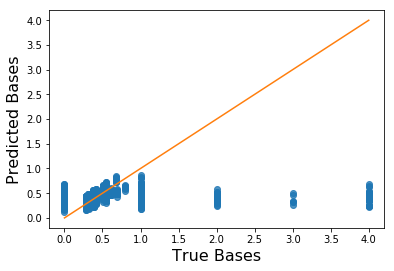

In [54]:
greedy_model = SGDRegressor(max_iter=5000)
greedy_model.fit(x_train, y_train)

greedy_pred_bases = greedy_model.predict(x_test)

sbn.regplot(x=y_test, y=greedy_pred_bases, fit_reg=False)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)])
plt.xlabel("True Bases", fontsize=16)
plt.ylabel("Predicted Bases", fontsize=16)

## Conclusion

The analysis of the PITCHf/x data revealed much about the relationship between many of the features that describe the pitch that was thrown and the situation it was thrown in. Exploring each of the relevant features showed that the variables with the strongest correlation to bases yielded were the pitch count (balls and strikes) and the matchup between pitcher and batter handedness. Another factor, related to pitch count, that seemed to be correlated to bases yielded was how many pitches were thrown in an at-bat. These correlations point to the conclusion that the situation the pitch is thrown in has the biggest effect on the outcome of the pitch. As far as the variables that describe the actual pitch, the pitch type, zone, and release position are the three factors that seem to be the most predictive of outcome of the pitch. All of these features have proven to be strong predictors when making predictions between 0 and 1 bases yielded, but none of the models were able to predict when the batter was going to hit the ball or gain more than 1 base. Further analysis into the fielding and batting information may give more insight into when the ball will be hit.